In [1]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.callbacks import TensorBoard
from IPython.display import clear_output

import pydicom
import skimage.io
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Display code for image and label
def display_im_label(img, lbl, titlef=""): # display the MR images along with ground truth labels

    mask = np.ma.masked_where(lbl == 0, lbl)
    clear_output(wait=True) # clear figure
    plt.figure(figsize=(5,5))
    # show MR image
    plt.imshow(img, cmap='gray')
    plt.imshow(mask, alpha=0.3)
    plt.axis('off')

    plt.pause(0.01)

In [3]:
# Normalize image using 5th and 95th percentile values
def im_normalize(img):
    im_min, im_max = np.percentile(img,[5,95])
    return np.clip(np.array((img-im_min)/(im_max-im_min), dtype=np.float32), 0.0, 1.0)

In [4]:
# Perform image cropping from center
def crop_center(img, lbl, crx, cry):
    y, x = img.shape
    sx = x//2-(crx//2)
    sy = y//2-(cry//2)
    return img[sy:sy+cry,sx:sx+crx], lbl[sy:sy+cry,sx:sx+crx]

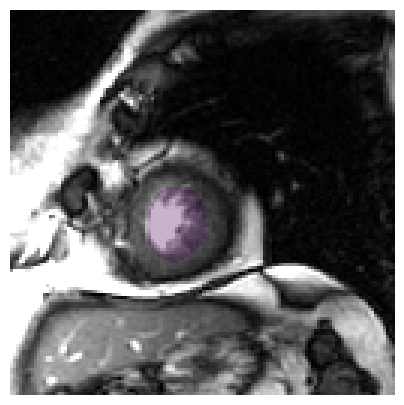

In [5]:
# Load images and labels
train_dir = os.path.join('lv_deeplearning','training')
SZ = 128 #Size
fimg_names = glob.glob(os.path.join(train_dir,'*.dcm'))

train_img, train_lbl = [], []
for fimg in fimg_names:
    ds = pydicom.read_file(fimg)
    lbl = skimage.io.imread("{}.png".format(fimg[:-4]))
    img = im_normalize(ds.pixel_array)
    img, lbl = crop_center(img,lbl,SZ,SZ)

    train_img.append(img)
    train_lbl.append(lbl)

    display_im_label(img,lbl)

In [6]:
# Set train image and label dimensions to 4 to be compatible with keras
train_img = np.array(train_img)[...,np.newaxis]
train_lbl = (np.array(train_lbl)[...,np.newaxis]>0).astype(np.float32)

In [7]:
# Define loss function and evaluation metric

eps = 1e-5

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + eps) / (K.sum(y_true_f) + K.sum(y_pred_f) + eps)

def dice_coef_loss(y_true, y_pred):
    return 1.0-dice_coef(y_true, y_pred)

In [8]:
# UNet neural network model definition
def get_unet():
    inputs = Input((SZ, SZ, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    return model

In [14]:
# Set neural network hyperparameters
N_EPOCHS = 100
LEARN_R = 5e-4
BATCH_SZ = 4

model = get_unet()
model.compile(optimizer=Adam(learning_rate=LEARN_R), loss=dice_coef_loss, metrics=[dice_coef])

In [15]:
# Create neural network model and print its details
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [16]:
# Perform neural network training
print("train img", train_img.shape, type(train_img[0,0,0,0]), np.min(train_img), np.max(train_img))
print("train lbl", train_lbl.shape, type(train_lbl[0,0,0,0]), np.min(train_lbl), np.max(train_lbl))
print("Training data loaded successfully.\n")

print("Loading network...")
model_checkpoint = ModelCheckpoint(os.path.join('trained_models', 'trained_unet.h5'), monitor='val_loss', save_best_only=True)
tbCallBack = TensorBoard(log_dir=os.path.join('trained_models', 'Graph', "train_ep{:04d}_lr{}_bsz_{:02d}".format(N_EPOCHS, LEARN_R, BATCH_SZ)), write_graph=False, write_images=False)
print("Network loaded successfully.")

print("Starting network training ...")
model.fit(train_img, train_lbl, batch_size=BATCH_SZ, epochs=N_EPOCHS, verbose=1, validation_split=0.2, callbacks=[model_checkpoint,tbCallBack])
print("Network trained successfully.")

K.clear_session()

print("done.")

train img (60, 128, 128, 1) <class 'numpy.float32'> 0.0 1.0
train lbl (60, 128, 128, 1) <class 'numpy.float32'> 0.0 1.0
Training data loaded successfully.

Loading network...
Network loaded successfully.
Starting network training ...
Epoch 1/100
12/12 [==============================] - 2s 100ms/step - loss: 0.8330 - dice_coef: 0.1670 - val_loss: 0.8943 - val_dice_coef: 0.1057
Epoch 2/100
12/12 [==============================] - 1s 77ms/step - loss: 0.8048 - dice_coef: 0.1952 - val_loss: 0.8657 - val_dice_coef: 0.1343
Epoch 3/100
12/12 [==============================] - 1s 81ms/step - loss: 0.7918 - dice_coef: 0.2082 - val_loss: 0.8574 - val_dice_coef: 0.1426
Epoch 4/100
12/12 [==============================] - 1s 75ms/step - loss: 0.6995 - dice_coef: 0.3005 - val_loss: 0.7886 - val_dice_coef: 0.2114
Epoch 5/100
12/12 [==============================] - 0s 25ms/step - loss: 0.6001 - dice_coef: 0.3999 - val_loss: 0.8006 - val_dice_coef: 0.1994
Epoch 6/100
12/12 [==========================